# Máy học nâng cao - Lab 04
# Họ tên: Nguyễn Phú Thành - MSSV: 18110014

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2 as L2_Regularizer

# Bài tập: Hãy code thử mạng Resnet50


In [2]:
# Residual block cho Resnet50
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters = 64, kernel_regularizer = None, down_sampling = False, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.n_filters, self.kernel_regularizer, self.down_sampling = n_filters, kernel_regularizer, down_sampling
    
    def get_config(self):
        config = super(ResidualBlock, self).get_config()
        config.update({
            'n_filters': self.n_filters,
            'down_sampling': self.down_sampling,
            'kernel_regularizer': self.kernel_regularizer
        })
        return config
    
    def build(self, input_shape):
        self.projection_shortcut = (int(input_shape[-1]) != (4*self.n_filters)) or self.down_sampling
        first_strides = (2, 2) if self.down_sampling else (1, 1)

        self.main_conv_1 = Convolution2D(
            filters = self.n_filters, 
            kernel_size = (1, 1), 
            strides = first_strides,
            padding = 'same',
            kernel_regularizer = self.kernel_regularizer,
            activation = None
        )
        self.main_batch_1 = BatchNormalization()
        self.main_relu_1 = ReLU()

        self.main_conv_2 = Convolution2D(
            filters = self.n_filters,
            kernel_size = (3, 3),
            strides = (1, 1),
            padding = 'same',
            kernel_regularizer = self.kernel_regularizer,
            activation = None
        )
        self.main_batch_2 = BatchNormalization()
        self.main_relu_2 = ReLU()

        self.main_conv_3 = Convolution2D(
            filters = 4 * self.n_filters,
            kernel_size = (1, 1),
            strides = (1, 1),
            padding = 'same',
            kernel_regularizer = self.kernel_regularizer,
            activation = None
        )
        self.main_batch_3 = BatchNormalization()

        if self.projection_shortcut:
            self.shortcut_conv = Convolution2D(
                filters = 4 * self.n_filters,
                kernel_size = (1, 1),
                strides = first_strides,
                padding = 'same',
                kernel_regularizer = self.kernel_regularizer,
                activation = None
            )
            self.shortcut_batch = BatchNormalization()
        
        self.main_relu_3 = ReLU()
    
    def call(self, inputs):
        main_conv_1 = self.main_conv_1(inputs)
        main_batch_1 = self.main_batch_1(main_conv_1)
        main_relu_1 = self.main_relu_1(main_batch_1)

        main_conv_2 = self.main_conv_2(main_relu_1)
        main_batch_2 = self.main_batch_2(main_conv_2)
        main_relu_2 = self.main_relu_2(main_batch_2)

        main_conv_3 = self.main_conv_3(main_relu_2)
        main_batch_3 = self.main_batch_3(main_conv_3)

        if self.projection_shortcut:
            shortcut_conv = self.shortcut_conv(inputs)
            shortcut_batch = self.shortcut_batch(shortcut_conv)
            shortcut = shortcut_batch
        else:
            shortcut = inputs
        main_add = main_batch_3 + shortcut
        main_relu_3 = self.main_relu_3(main_add)
        return main_relu_3

In [3]:
class GroupResiduals(tf.keras.layers.Layer):
    def __init__(self, n_filters, n_blocks, kernel_regularizer = None, down_sampling = False, **kwargs):
        super(GroupResiduals, self).__init__(**kwargs)
        self.n_filters, self.n_blocks, self.kernel_regularizer, self.down_sampling = (
            n_filters,  
            n_blocks, 
            kernel_regularizer, 
            down_sampling
        )
    
    def get_config(self):
        config = super(GroupResiduals, self).get_config()
        config.update({
            'n_filters': self.n_filters,
            'n_blocks': self.n_blocks,
            'kernel_regularizer': self.kernel_regularizer,
            'down_sampling': self.down_sampling
        })
        return config

    def build(self, input_shape):
        self.residual_blocks = []
        shape = (int(input_shape[-1]),)
        for i in range(self.n_blocks):
            down_sampling = self.down_sampling if i == 0 else False
            residual_block = ResidualBlock(
                n_filters = self.n_filters, 
                kernel_regularizer = self.kernel_regularizer, 
                down_sampling = down_sampling
            )
            residual_block.build(shape)
            self.residual_blocks.append(residual_block)
            shape = (int(residual_block.main_conv_3.filters),)
    
    def call(self, inputs):
        outputs = inputs
        for i in range(self.n_blocks):
            outputs = self.residual_blocks[i].call(outputs)
        return outputs

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train.astype(np.float)/255.0, X_test.astype(np.float)/255.0

# Resize lại ảnh vì Resnet chỉ chấp nhận ảnh có kích thước tối thiểu là (32, 32)
X_train = np.array([cv2.resize(img, dsize = (32,32)) for img in X_train])
X_test = np.array([cv2.resize(img, dsize = (32,32)) for img in X_test])

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0)

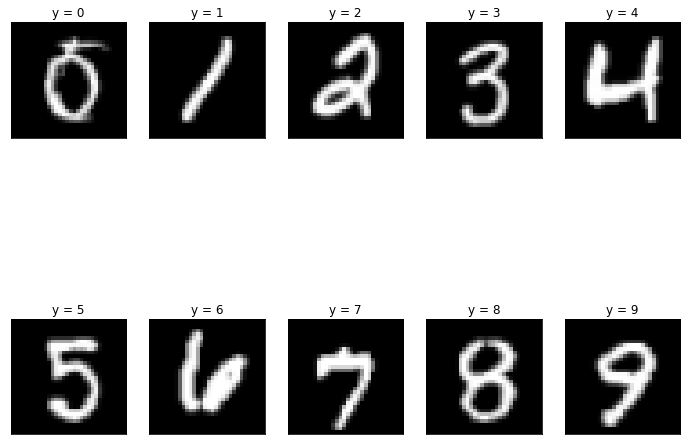

In [6]:
fig, axes = plt.subplots(figsize = (12, 10), nrows = 2, ncols = 5)
rnd = np.random.RandomState(42)
for label, ax in zip(np.unique(y_train), axes.flatten()):
    subset = X_train[(y_train == label).flatten()]
    index = rnd.choice(subset.shape)
    ax.imshow(subset[index - 1], cmap = plt.cm.gray)
    ax.set(title = f'y = {label}', xticks = [], yticks = [])
plt.show()

In [7]:
l2_regularizer_rate = 1e-5

inputs = tf.keras.layers.Input(shape = (32, 32))
reshape = tf.keras.layers.Reshape((32, 32, 1))(inputs)

conv_1 = Convolution2D(
    filters = 64, 
    kernel_size = (7, 7), 
    strides = (2, 2), 
    padding = 'same',
    kernel_regularizer = L2_Regularizer(l2 = l2_regularizer_rate),
    activation = None
)(reshape)

batch_1 = BatchNormalization()(conv_1)
relu_1 = ReLU()(batch_1)
maxpool = MaxPool2D(pool_size = (3, 3), strides = (2, 2))(relu_1)

# Block 1
group_residuals_1 = GroupResiduals(
    n_filters = 64, n_blocks = 3, kernel_regularizer = L2_Regularizer(l2 = l2_regularizer_rate), down_sampling = False
)(maxpool)

# Block 2
group_residuals_2 = GroupResiduals(
    n_filters = 128, n_blocks = 4, kernel_regularizer = L2_Regularizer(l2 = l2_regularizer_rate), down_sampling = True
)(group_residuals_1)

# Block 3
group_residuals_3 = GroupResiduals(
    n_filters = 256, n_blocks = 6, kernel_regularizer = L2_Regularizer(l2 = l2_regularizer_rate), down_sampling = True
)(group_residuals_2)

# Block 4
group_residuals_4 = GroupResiduals(
    n_filters = 512, n_blocks = 3, kernel_regularizer = L2_Regularizer(l2 = l2_regularizer_rate), down_sampling = True
)(group_residuals_3)

average_pooling = GlobalAveragePooling2D()(group_residuals_4)
outputs = Dense(units = 10, activation = tf.nn.softmax)(average_pooling)

model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
group_residuals (GroupResidu (None, 7, 7, 256)         220032

In [8]:
# So sánh tổng số lượng param với API của tensorflow
tf.keras.applications.ResNet50(
    include_top = True,
    weights = None,
    input_shape = (32, 32, 1),
    pooling = None,
    classes=10
).summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
N_EPOCHS, BATCH_SIZE, INITIAL_LR = 15, 256, 5e-5

In [10]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = INITIAL_LR, momentum = 0.9, nesterov = True),
    loss = tf.keras.losses.sparse_categorical_crossentropy, 
    metrics = ["accuracy",]
)

In [11]:
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath = "epoch: {epoch:02d}.hdf5", 
    monitor = 'val_loss',
    mode = 'min', 
    verbose = 0,
    save_best_only = False
)

In [12]:
history = model.fit(
    X_train, y_train,
    epochs = N_EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (X_valid, y_valid),
    callbacks = (mc,)
)

Epoch 1/15
211/211 [==============================] - 93s 253ms/step - loss: 2.9771 - accuracy: 0.1772 - val_loss: 2.5418 - val_accuracy: 0.1008
Epoch 2/15
211/211 [==============================] - 48s 228ms/step - loss: 1.8850 - accuracy: 0.4366 - val_loss: 1.7738 - val_accuracy: 0.4460
Epoch 3/15
211/211 [==============================] - 48s 228ms/step - loss: 1.1972 - accuracy: 0.6645 - val_loss: 1.0101 - val_accuracy: 0.7257
Epoch 4/15
211/211 [==============================] - 48s 228ms/step - loss: 0.8624 - accuracy: 0.7796 - val_loss: 0.7426 - val_accuracy: 0.8185
Epoch 5/15
211/211 [==============================] - 48s 228ms/step - loss: 0.6714 - accuracy: 0.8446 - val_loss: 0.6270 - val_accuracy: 0.8538
Epoch 6/15
211/211 [==============================] - 48s 229ms/step - loss: 0.5647 - accuracy: 0.8787 - val_loss: 0.5430 - val_accuracy: 0.8837
Epoch 7/15
211/211 [==============================] - 48s 229ms/step - loss: 0.4902 - accuracy: 0.9036 - val_loss: 0.4855 - val_ac

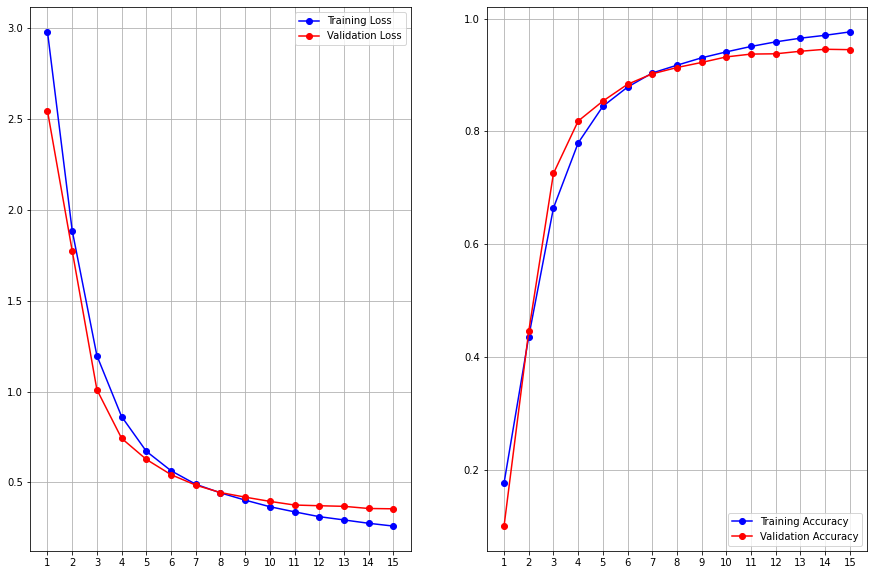

In [13]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10))
axes[0].plot(np.arange(1, N_EPOCHS + 1), history.history['loss'], color = 'b', marker = 'o', label = 'Training Loss')
axes[0].plot(np.arange(1, N_EPOCHS + 1), history.history['val_loss'], color = 'r', marker = 'o', label = 'Validation Loss')
axes[0].set(xticks = np.arange(1, N_EPOCHS + 1))
axes[0].grid(True)
axes[0].legend()

axes[1].plot(np.arange(1, N_EPOCHS + 1), history.history['accuracy'], color = 'b', marker = 'o', label = 'Training Accuracy')
axes[1].plot(np.arange(1, N_EPOCHS + 1), history.history['val_accuracy'], color = 'r', marker = 'o', label = 'Validation Accuracy')
axes[1].set(xticks = np.arange(1, N_EPOCHS + 1))
axes[1].grid(True)
axes[1].legend(loc = "lower right")

# Nhận xét: Tại epoch thứ 11, loss và accuracy trên tập train và tập validation không sai khác đáng kể, do đó ta chọn trọng số tại epoch này làm trọng số cho mô hình

In [14]:
custom_objects = {"ResidualBlock": ResidualBlock, "GroupResiduals": GroupResiduals, "L2": L2_Regularizer}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model("/content/epoch: 11.hdf5")
result = model.evaluate(X_test, y_test, verbose = 0)
print("Loss và Accuracy trên tập test của mô hình được chọn là {} {}".format(result[0],result[1]))

Loss và Accuracy trên tập test của mô hình được chọn là 0.3968242406845093 0.9326000213623047
